In [3]:
from statsmodels.tsa.arima_model import ARMA
from pathlib import Path
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import timedelta
import warnings

In [2]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")
# Read the financial data 
fin_path = ONEDRIVE_PATH / "Input Data/stock_data.pkl"
fin_data = pd.read_pickle(fin_path)
fin_data = fin_data.loc['2006-09-01' : '2013-11-22']

# Create dataframe with percental difference 
fin_pct = fin_data.pct_change()
fin_pct = fin_pct.drop(index=fin_pct.index[0])

In [3]:
news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)

news_dates = news_data.index.drop_duplicates()
fin_dates = fin_data.index.drop_duplicates

# Find the dates which are present in both the financial data and news data
valid_dates = []
for date in news_dates: 
    if date in fin_data.index: 
        valid_dates.append(date)

Save plots of the regular time series and the percentual change between each day. 

In [167]:
plot_path = Path(os.getcwd()) / "ARMA figs"
plt.plot(fin_data['1 YEAR'],label='1 YEAR RATE',linewidth=0.5)
plt.legend() 
plt.savefig(plot_path / "1yr.pdf",format='pdf')
plt.clf()
plt.plot(fin_data['3 YEAR'], label='3 YEAR RATE',linewidth=0.5)
plt.legend() 
plt.savefig(plot_path / "3yr.pdf",format='pdf')
plt.clf()
plt.plot(fin_data['S&P'], label='S&P 500',linewidth=0.5)
plt.legend() 
plt.savefig(plot_path / "sp.pdf",format='pdf')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [168]:
plot_path = Path(os.getcwd()) / "ARMA figs"
plt.plot(fin_pct['1 YEAR'],label='1 YEAR RATE',linewidth=0.5)
plt.legend() 
plt.savefig(plot_path / "1yr_pct.pdf",format='pdf')
plt.clf()
plt.plot(fin_pct['3 YEAR'], label='3 YEAR RATE',linewidth=0.5)
plt.legend() 
plt.savefig(plot_path / "3yr_pct.pdf",format='pdf')
plt.clf()
plt.plot(fin_pct['S&P'], label='S&P 500',linewidth=0.5)
plt.legend() 
plt.savefig(plot_path / "sp_pct.pdf",format='pdf')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [35]:
def try_fit(data,start,maxiter=1000,disp=0,internal_request=False): 
    # Test several optimization routines to get convergence
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try: 
            m = ARMA(data,order=(1,1))
            m_fit = m.fit(start_params=start,maxiter=maxiter,solver="powell",disp=disp)
            return m_fit
        except Warning as e: 
            pass
        try: 
            m = ARMA(data,order=(1,1))
            m_fit = m.fit(start_params=start,maxiter=maxiter,solver="lbfgs",disp=disp)
            return(m_fit)
        except Warning as e: 
            pass
        try:
            m = ARMA(data,order=(1,1))
            m_fit = m.fit(start_params=start,maxiter=maxiter,solver="bfgs",disp=disp)
            return(m_fit)
        except Warning as e: 
            pass
        try:
            m = ARMA(data,order=(1,1))
            m_fit = m.fit(start_params=start,maxiter=maxiter,solver="newton",disp=disp)
            return(m_fit)
        except Warning as e: 
            pass
        try:
            m = ARMA(data,order=(1,1))
            m_fit = m.fit(start_params=start,maxiter=maxiter,solver="nm",disp=disp)
            return(m_fit)
        except Warning as e: 
            pass
        try:
            m = ARMA(data,order=(1,1))
            m_fit = m.fit(start_params=start,maxiter=maxiter,solver="cg",disp=disp)
            return(m_fit)
        except Warning as e: 
            pass
        try:
            m = ARMA(data,order=(1,1))
            m_fit = m.fit(start_params=start,maxiter=maxiter,solver="ncg",disp=disp)
            return(m_fit)
        except Warning as e: 
            pass
    if not internal_request:
        return try_fit(data,start=(0.5,0.5),maxiter=2*maxiter, internal_request=True)
    else:
        # If no solution was found after two tries with different start_params
        # and solvers, we'll just return a suboptimal solution. 
        print("Suboptimal solution returned.")
        m = ARMA(data,order=(1,1))
        m_fit = m.fit(start_params=start,maxiter=maxiter,solver="ncg",disp=disp)
        return m_fit

### Next day predictions
We fit a model given the filtration at time $t$ and then make a prediction. Since the prediction are linear in time, a negative prediction for day $k$ implies a negative prediction for day $k + \delta$ for all $\delta$. 

In [67]:
relative_preds = np.zeros((len(valid_dates), 3))
start = [0,0,0]
for i,date in enumerate(tqdm(valid_dates)): 
    for j,series in enumerate(fin_pct):
        temp_fit = try_fit(fin_pct.loc[:date][series].values,start)
        forec = temp_fit.forecast(steps=1)[0][0]
        relative_preds[i,j] = forec
        start = temp_mod.params
        

100%|████████████████████████████████████████████████████████████████████████████| 1846/1846 [1:10:26<00:00,  2.29s/it]


Create a matrix with 0 for equal or lower prediction and 1 for higher prediction, compared to the present value.  

In [110]:
# Predicted movements 
relative_preds_binary = (relative_preds[:-1] > 0).astype(int)
# Actual movements 
true_movements = (fin_pct.loc[valid_dates[1:]].values > 0).astype(int)

In [139]:
accuracy_matrix = (relative_preds_binary == true_movements).astype(int)
savename_1 = Path(os.getcwd()) / "arma_accuracy.npy"
np.save(savename_1, accuracy_matrix)

In [141]:
# Was the actual percentual change smaller/larger than the ARMA-prediction? 
arma_labels = (fin_pct.loc[valid_dates].values < relative_preds).astype(int) # 0 for outcome > pred
savename_2 = Path(os.getcwd()) / "arma_labels.npy"
np.save(savename_2, arma_labels)

In [3]:
savename_1 = Path(os.getcwd()) / "arma_accuracy.npy"
accuracy_matrix = np.load(savename_1)

In [14]:

np.mean(accuracy_matrix,axis=0)

array([0.65907859, 0.5604336 , 0.47588076])

In [1]:
my_accs = [69.2, 59.9, 59.1]
rand_accs = [68.9, 59.4, 53.6]

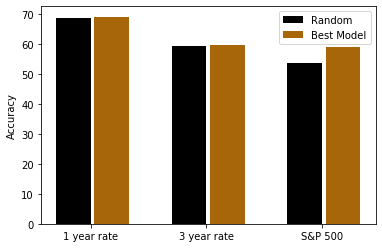

In [39]:
N = 3
ind = np.arange(N)
width = 0.3

fig = plt.figure() 
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, rand_accs,width,color='#000000')
rects2 = ax.bar(ind+width + 0.03, my_accs,width,color='#a76609')

ax.set_ylabel('Accuracy')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['1 year rate', '3 year rate', 'S&P 500'])
ax.legend(['Random','Best Model'])
plt.savefig('summary',format='pdf')